In [0]:
import numpy as np
import pandas as pd
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [2]:
df = pd.read_csv('file_for_code.csv')
# df = pd.read_csv('file_for_code.csv', index_col='Date',parse_dates=True)

df

,Date,time,smd_temp,smd_RH,amb_temp,amb_RH,amb_temp1,amb_temp2,amb_RH_next1,amb_RH_next2,TRAINE1,TRAINE2,TRAINE3,SMD,chiller_state
0,04-01-2017,7,26.5,63.07,22.2,75.0,27.2,32.8,56.0,56.0,0.0,0.0,0.0,98.0,0
1,04-01-2017,8,27.7,64.14,27.2,56.0,27.2,32.8,56.0,40.0,0.0,0.0,0.0,167.0,0
2,04-01-2017,9,27.7,64.14,27.2,56.0,32.8,36.7,40.0,40.0,0.0,0.0,8.0,299.0,0
3,04-01-2017,10,26.4,63.86,32.8,40.0,32.8,36.7,40.0,26.0,10.0,107.0,120.0,392.0,1
4,04-01-2017,11,26.4,63.86,32.8,40.0,36.7,37.2,26.0,26.0,32.0,50.0,152.0,419.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19111,10-31-2019,2,25.8,63.36,20.0,84.0,20.0,18.9,84.0,95.0,0.0,0.0,1.0,685.0,0
19112,10-31-2019,3,25.8,63.36,20.0,84.0,18.9,18.9,95.0,95.0,0.0,0.0,1.0,691.0,0
19113,10-31-2019,4,25.9,63.71,18.9,95.0,18.9,18.9,95.0,95.0,101.0,16.0,16.0,715.0,0
19114,10-31-2019,5,25.9,63.71,18.9,95.0,18.9,18.8,95.0,95.0,40.0,6.0,21.0,729.0,0


In [0]:
df["Date"] = pd.to_datetime(df["Date"])
df["month"] = df["Date"].dt.month
df["year"] = df["Date"].dt.year
df["day"] = df["Date"].dt.day

In [4]:
print(df.columns)
df.dropna(axis=0 , inplace=True)
df.head()
df.info()
df.isnull().values.any()

Index(['Date', 'time', 'smd_temp', 'smd_RH', 'amb_temp', 'amb_RH', 'amb_temp1',
       'amb_temp2', 'amb_RH_next1', 'amb_RH_next2', 'TRAINE1', 'TRAINE2',
       'TRAINE3', 'SMD', 'chiller_state', 'month', 'year', 'day'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19113 entries, 0 to 19115
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           19113 non-null  datetime64[ns]
 1   time           19113 non-null  int64         
 2   smd_temp       19113 non-null  float64       
 3   smd_RH         19113 non-null  float64       
 4   amb_temp       19113 non-null  float64       
 5   amb_RH         19113 non-null  float64       
 6   amb_temp1      19113 non-null  float64       
 7   amb_temp2      19113 non-null  float64       
 8   amb_RH_next1   19113 non-null  float64       
 9   amb_RH_next2   19113 non-null  float64       
 10  TRAINE1        19113 non-null  

False

In [5]:
df.head()

,Date,time,smd_temp,smd_RH,amb_temp,amb_RH,amb_temp1,amb_temp2,amb_RH_next1,amb_RH_next2,TRAINE1,TRAINE2,TRAINE3,SMD,chiller_state,month,year,day
0,2017-04-01,7,26.5,63.07,22.2,75.0,27.2,32.8,56.0,56.0,0.0,0.0,0.0,98.0,0,4,2017,1
1,2017-04-01,8,27.7,64.14,27.2,56.0,27.2,32.8,56.0,40.0,0.0,0.0,0.0,167.0,0,4,2017,1
2,2017-04-01,9,27.7,64.14,27.2,56.0,32.8,36.7,40.0,40.0,0.0,0.0,8.0,299.0,0,4,2017,1
3,2017-04-01,10,26.4,63.86,32.8,40.0,32.8,36.7,40.0,26.0,10.0,107.0,120.0,392.0,1,4,2017,1
4,2017-04-01,11,26.4,63.86,32.8,40.0,36.7,37.2,26.0,26.0,32.0,50.0,152.0,419.0,1,4,2017,1


In [0]:
np.random.seed(7)
classes_req =  ['time', 'smd_temp', 'smd_RH', 'amb_temp', 'amb_RH', 'SMD', 'chiller_state', 'month', 'year', 'day']
df = df[classes_req]      

In [0]:
target_names = ['chiller_state']

In [0]:
shift_days = 1
shift_steps = shift_days * 2 

In [0]:

df_targets = df[target_names].shift(-shift_steps)

In [10]:
df_targets.head()

,chiller_state
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0


In [11]:
df[target_names].head(shift_steps + 5)

,chiller_state
0,0
1,0
2,0
3,1
4,1
5,1
6,1


In [12]:
df_targets.head(5)

,chiller_state
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0


In [13]:
df_targets.tail()

,chiller_state
19111,0.0
19112,0.0
19113,0.0
19114,NaN
19115,NaN


In [14]:
x_data = df.values[0:-shift_steps]
x_data

array([[7.000e+00, 2.650e+01, 6.307e+01, ..., 4.000e+00, 2.017e+03,
        1.000e+00],
       [8.000e+00, 2.770e+01, 6.414e+01, ..., 4.000e+00, 2.017e+03,
        1.000e+00],
       [9.000e+00, 2.770e+01, 6.414e+01, ..., 4.000e+00, 2.017e+03,
        1.000e+00],
       ...,
       [2.000e+00, 2.580e+01, 6.336e+01, ..., 1.000e+01, 2.019e+03,
        3.100e+01],
       [3.000e+00, 2.580e+01, 6.336e+01, ..., 1.000e+01, 2.019e+03,
        3.100e+01],
       [4.000e+00, 2.590e+01, 6.371e+01, ..., 1.000e+01, 2.019e+03,
        3.100e+01]])

In [15]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (19111, 10)


In [16]:
y_data = df_targets.values[:-shift_steps]
y_data

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [17]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (19111, 1)


In [18]:
num_data = len(x_data)
num_data

19111

In [19]:
train_split = 0.9
num_train = int(train_split * num_data)
num_train

17199

In [20]:
num_test = num_data - num_train
num_test

1912

In [21]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

19111

In [22]:
num_x_signals = x_data.shape[1]
num_x_signals

10

In [23]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [24]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_train_scaled
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)


19111

In [25]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [26]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -17.8
Max: 2019.0


In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [28]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(17199, 10)
(17199, 1)


In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [0]:
batch_size = 1024

In [31]:
sequence_length = 24 * 7 * 8
sequence_length

1344

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [34]:
print(x_batch.shape)
print(y_batch.shape)

(128, 1344, 10)
(128, 1344, 1)


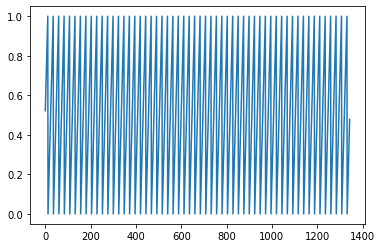

In [35]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

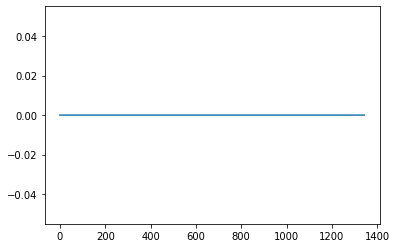

In [36]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

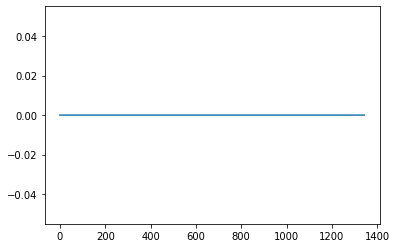

In [37]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [0]:
validation_data = (np.expand_dims(x_scaler.fit_transform(x_test), axis=0),
                   np.expand_dims(y_scaler.transform(y_test), axis=0))


In [0]:
model = Sequential()

In [0]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [0]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [0]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [0]:
warmup_steps = 50

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse


In [0]:
optimizer = RMSprop(lr=1e-3)

In [0]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         804864    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 805,377
Trainable params: 805,377
Non-trainable params: 0
_________________________________________________________________


In [0]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [0]:
callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [53]:
%%time
model.fit(x=generator,
          epochs=100,
          steps_per_epoch=1024,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.1008
Epoch 00001: val_loss improved from inf to 0.11517, saving model to checkpoint.keras
100/100 [==============================] - 50s 505ms/step - loss: 0.1008 - val_loss: 0.1152 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0656
Epoch 00002: val_loss improved from 0.11517 to 0.10150, saving model to checkpoint.keras
100/100 [==============================] - 50s 502ms/step - loss: 0.0656 - val_loss: 0.1015 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0578
Epoch 00003: val_loss improved from 0.10150 to 0.08272, saving model to checkpoint.keras
100/100 [==============================] - 50s 503ms/step - loss: 0.0578 - val_loss: 0.0827 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0537
Epoch 00004: val_loss did not improve from 0.08272

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [55]:
result = model.evaluate(x=np.expand_dims(x_scaler.fit_transform(x_test), axis=0),
                        y=np.expand_dims(y_scaler.transform(y_test), axis=0))

1/1 [==============================] - 0s 4ms/step - loss: 0.0827


In [56]:
print("loss (test-set):", result)

loss (test-set): 0.08271842449903488


In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

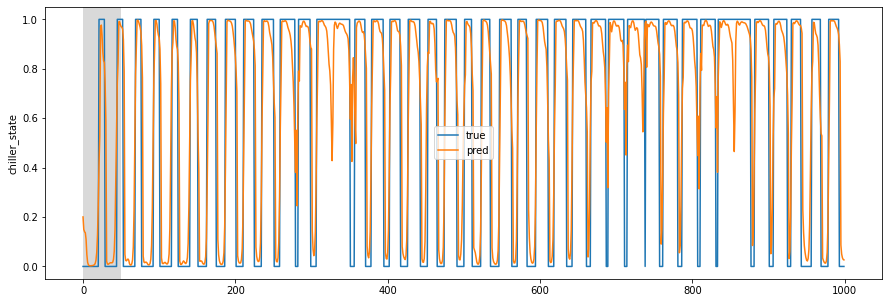

In [58]:
plot_comparison(start_idx=100, length=1000, train=True)

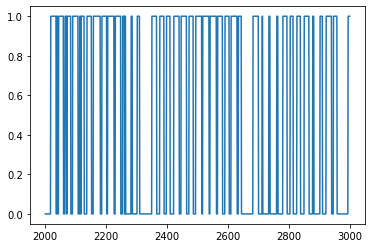

In [59]:
df['chiller_state'][2000:2000+1000].plot();

In [0]:
# testing the model results
y_test.shape
target_names = ['time', 'smd_temp', 'smd_RH', 'amb_temp', 'amb_RH', 'SMD', 'chiller_state', 'month', 'year', 'day']

In [61]:
x_test[0]


array([7.000e+00, 2.660e+01, 6.429e+01, 2.940e+01, 8.000e+01, 5.730e+02,
       1.000e+00, 7.000e+00, 2.019e+03, 3.000e+01])

In [0]:
x = x_train_scaled
y_true = y_train

In [63]:
start_idx = 50
length = 1
end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
x = x[start_idx:end_idx]
y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
x.shape

(1, 1, 10)

In [64]:
y_pred_rescaled.shape



(1, 1)

In [65]:
y_pred_rescaled

array([[0.89194584]], dtype=float32)

In [66]:
y_true

array([[1.]])

In [0]:
# steps for prediction
# create an array 
# a = []
# of values in order
# ['time', 'smd_temp', 'smd_RH', 'amb_temp', 'amb_RH', 'SMD', 'chiller_state', 'month', 'year', 'day']

#        where time is the hour 
# example
array_example =  [ 7.  ,  26.6 ,  64.29,  29.4 ,  80.  , 573.  ,   1., 6,2017 ,4  ] 
         


In [68]:
x_scaler = MinMaxScaler()
array_example = x_scaler.fit_transform(np.array(array_example).reshape(-1,1))
array_example.shape
array_example

array([[0.00297619],
       [0.01269841],
       [0.03139385],
       [0.0140873 ],
       [0.03918651],
       [0.28373016],
       [0.        ],
       [0.00248016],
       [1.        ],
       [0.0014881 ]])

In [69]:
array_example = np.reshape(array_example , (1,-1))
array_example.shape

(1, 10)

In [0]:
array_example = np.expand_dims(array_example, axis=0)
y_pred = model.predict(array_example)
# array_example.shape

In [71]:
y_pred

array([[[0.36139238]]], dtype=float32)

In [72]:
actual_state_pred = y_pred.round()
actual_state_pred

array([[[0.]]], dtype=float32)

In [0]:
# The above was the mthod to get prediction 24hrs in the future

# note that 
# dont asume that since x,y have same index they are of same date, the data is modified such that 
# y is 24hr ahead of x
# for testing purposes and training aswell

In [0]:
# finding accurary precision recall 
# for this i will use a set of test samples

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [0]:
x =x_scaler.fit_transform(x_test)
x = np.expand_dims(x, axis=0)
y_true = y_test
y_true = np.squeeze(y_true)
y_pred = model.predict(x)
y_pred = np.squeeze(y_pred)
y_pred = y_pred.round()


In [78]:
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy)

# precision 
precision = precision_score(y_true, y_pred)
print('Precision: %f' % precision)

# recall
recall = recall_score(y_true,y_pred)
print('Recall: %f' % recall)

Accuracy: 0.883368
Precision: 0.901804
Recall: 0.878049


In [0]:
# GRU is used for now is because lstm is takes up alot of vram and basic functionality of both of these is same 
# GRU is slightly faster too 
# both these algos provide good functionality for time series data

In [0]:
# # amking the csv
# we can take an example set of 50 rows
# for checking the corrrectness of data 
# see row and row+24th row 

# since the data for tests is shifted by 24rows that is 1 day to predict the required 1 day in future
# u can see indexed row and indexed row +24Th row

# for example
# if we have data in first row , the same corresponding chiller state will be found in y_true with a +24 index

In [0]:
x =x_scaler.fit_transform(x_test[:])
x = np.expand_dims(x, axis=0)
y_true = y_test[:]
y_true = np.squeeze(y_true)
y_pred = model.predict(x)
y_pred = np.squeeze(y_pred)
y_pred = y_pred.round()

In [82]:
# we append x_test , y_true , y_pred to csv
x_test[:].shape , y_true.shape ,y_pred.shape

((1912, 10), (1912,), (1912,))

In [0]:
all_items = {'given_val_time_t': x_test[:][: , 6],
        'actual_state_time_t+2hr': y_true,
        'predicted_state_time_t+2hr' : y_pred
        }

df = pd.DataFrame(all_items, columns= ['given_val_time_t', 'actual_state_time_t+2hr' ,'predicted_state_time_t+2hr' ])

In [0]:
df.to_csv("output.csv" , index=True)

In [85]:
df.head()

,given_val_time_t,actual_state_time_t+2hr,predicted_state_time_t+2hr
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0
